# Gaussian mixture model

In [7]:
# Load generated data from file:
import pickle

from evaluation import *

runs = []
num_chains = 10
for i in range(num_chains):
    with open(f"samples_produced/gmm_{i}__count1000_eps0.05_leapfrogsteps50.pickle", "rb") as f:
        runs.append(pickle.load(f))

In [13]:
all_methods = list(set(all_methods) - set(anglican_methods))

In [14]:
thinned_runs = thin_runs(all_methods, runs)
chains = collect_chains(all_methods, thinned_runs)
print_running_time(all_methods, runs, thinned_runs)


Running times:
hmc: 2143.20s    0.2143s per sample (after thinning)
is: 1571.89s    0.1572s per sample (after thinning)


In [15]:
import torch
import math
import example_gmm as gmm

def gmm_lppd(samples):
    M = len(samples)
    N = len(gmm.test_data)
    #compute the probability density for each data point and sapmle (size M x N):
    logps = torch.stack([gmm.loglikelihoods(torch.tensor(sample), gmm.test_data) for sample in samples])
    # average over all samples:
    logp_avg = torch.logsumexp(logps, dim=0) - math.log(float(M))
    # sum over all test data points:
    lppd = torch.sum(logp_avg)
    return lppd

def gmm_lppd_stats(chains):
    lppds = torch.tensor([gmm_lppd(chain) for chain in chains])
    std, mean = torch.std_mean(lppds)
    return mean.item(), std.item()

def print_gmm_lppd_stats(chains):
    mean, std = gmm_lppd_stats(chains)
    return f"{mean:.2f} +- {std:.2f} (standard deviation)"

print("Log posterior predictive densities:")
print(f"True LPPD:  {print_gmm_lppd_stats([[gmm.data_means.tolist()]])}")
for method in all_methods:
    print(f"{method}:  {print_gmm_lppd_stats(chains[method])}")

Log posterior predictive densities:
True LPPD:  -674.81 +- nan (standard deviation)
hmc:  -731.08 +- 0.00 (standard deviation)
is:  -725.98 +- 0.00 (standard deviation)


In [18]:
compared_methods = list(set(compared_methods) - set(anglican_methods))

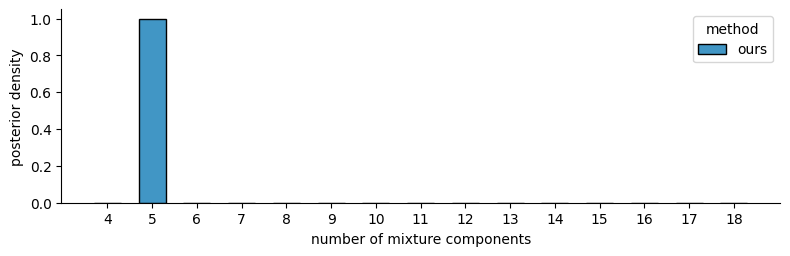

In [19]:
# Plot the number of mixture components
import pandas
import torch
import matplotlib.pyplot as plt
import seaborn as sns

def toListOfKs(xss):
    return [len(x) for xs in xss for x in xs]

data = []
for method in compared_methods:
    data += [(method_name[method], k) for k in toListOfKs(chains[method])]

x_label = "number of mixture components"
dataframe = pandas.DataFrame(data, columns=["method", x_label])
plot = sns.displot(
    data=dataframe,
    x=x_label,
    hue="method",
    stat="density",
    common_norm=False,
    discrete=True,
    binrange=(4,18),
    multiple="dodge",
    shrink=0.6,
    aspect=3.0,
    facet_kws={"legend_out": False},
    palette=palette,
    height=8/3,
)
plot.set_ylabels(label="posterior density")
plt.xticks([i for i in range(4, 19)])
plot.savefig("gmm-histogram.pdf", bbox_inches="tight")